In [1]:
"""
Analyze MW power traces for each shot of experiment from R&S NRP18S power meter.
"""

import h5py
import os
import numpy as np

#extract data from hdf5 file
absolute_path = os.path.abspath('')
rel_path = "MWPowerTraces_20240306.hdf" # mw power trace data
filename = os.path.join(absolute_path, rel_path)
run_names = ['run_183233', 'run_183713'] #run names we care about 

#input characterstic of power trace (duration of trace and number of points sampled). Comes from NRP18S.py file.
points = 200 #num of points in the trace measurement
duration = 100e-6 #in seconds

#open hdf file and extract data, initializing into a dict for further analysis
with h5py.File(filename, 'r') as hdf:
    #dict1 is reduced dict of {run names : run data} only for runs we care about
    dict1 = {key: hdf[key] for key in run_names if key in hdf} 
    runs = [None for _ in range(len(run_names))]
    for key_index, key in enumerate(dict1):
        run = dict1[key]
        num_shots = len(run)
        sorted_keys = sorted(run.keys(), key=int) #sort run keys by true numerical order (not "string numerical" order")
        
        #run_shot is a list of the shots in each run in true numerical order. each shot is one mw power trace.
        run_shot = [None for _ in range(num_shots)]
        for key2 in sorted_keys:
            run_shot[int(key2)] = run[key2] 

        #extract data from runs (make list of lists of times and mw powers)
        layers, rows, cols = num_shots, 2, points
        run_data = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(layers)]

        for i in range(num_shots):
            times, mw_power = zip(*run_shot[i])
            run_data[i][0] = np.asarray(times)
            run_data[i][1] = np.asarray(mw_power)
        
        runs[key_index] = run_data 

    #dict2 is dict of {run names : runs} where runs is a list of 3D list containing all data for each shot (trace time and mw power)
    #we create dict2 for convenience so it's easy to extract the data we want from it later
    #the val of dic2 (runs) is a 3D list of the form [shot number][time or power index][time or power value]
    dict2 = {key: runs[run_names.index(key)] for key in run_names}

In [2]:
#open dict2, extract power trace data, and initialize into 3d list for further analysis
#the val of dic2 (runs) is a 3D list of the form [shot number][time or power index][time or power value]

#all_data[i][j][k] is data for run i, index j (j=0 is time, j=1 is power), and shot k
#all_data holds all the data we care about from this day's data (corresponding to the hdf file)
rows, cols = len(run_names), num_shots
all_data = [[None for _ in range(cols)] for _ in range(rows)] 

#go through each run and assign the timing and power data accordingly
for key_index, key in enumerate(dict2):
    run = dict2[key]
    num_shots = len(run)

    all_timings = [col[0] for col in run[:]] #all_timings[i] is timing data for shot i
    all_powers = [col[1] for col in run[:]] #all_powers[i] is power data for shot i
    all_data[key_index] = [all_timings, all_powers]


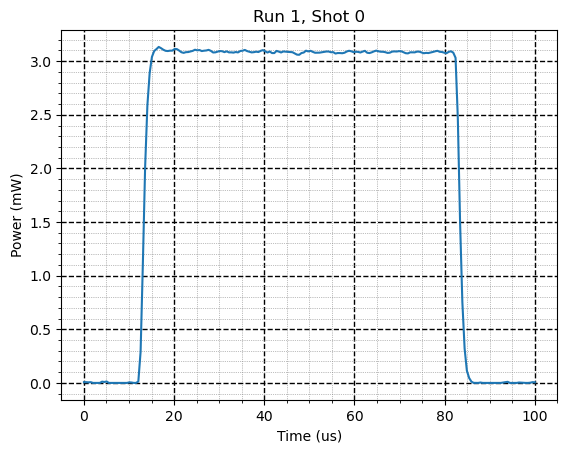

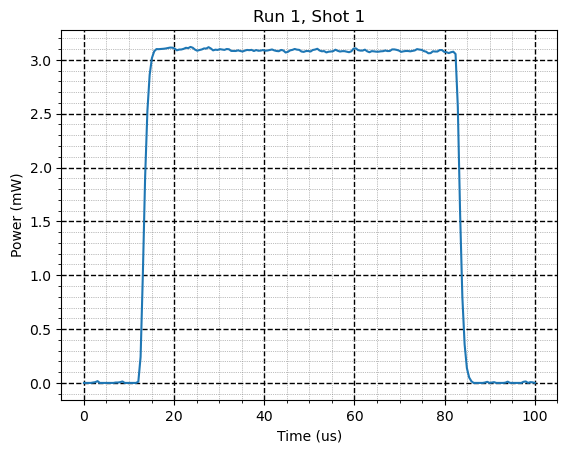

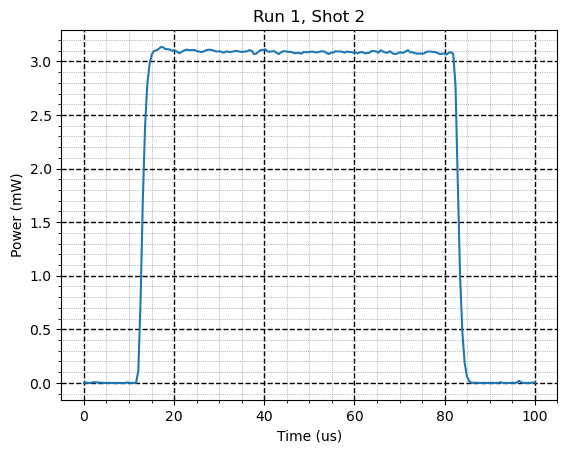

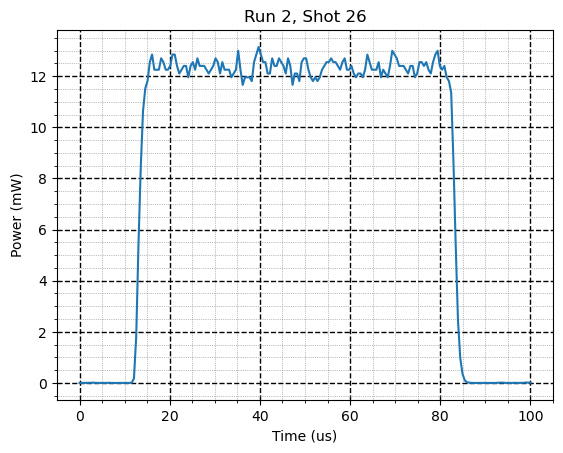

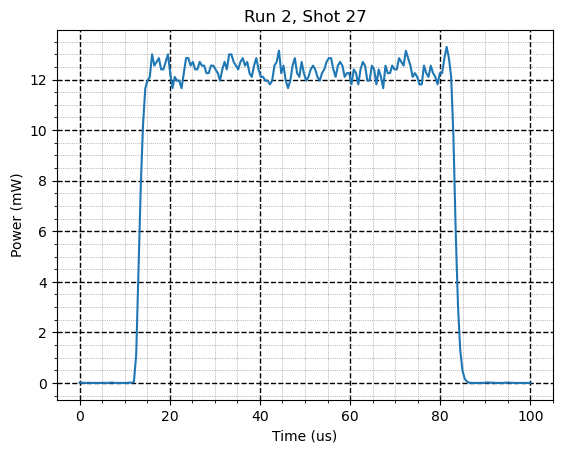

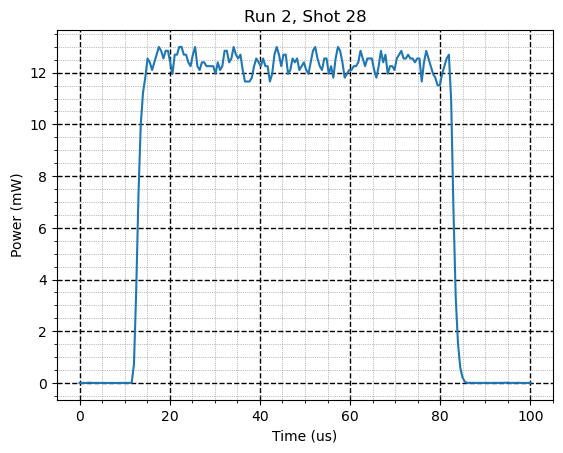

In [3]:
import matplotlib.pyplot as plt

#all_data now holds all the data we care about for this day's data.
#plot some example power traces from a run

#start with first run
run = all_data[0]
num_shots = len(run[0])
for i in range(3):
    plt.plot(run[0][i], run[1][i])
    plt.xlabel('Time (us)')
    plt.ylabel('Power (mW)')
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.title("Run 1, Shot " + str(i))
    #plt.savefig('run1_shot' + str(i) + '.png')
    plt.show()


#now plot some example power traces from the second run
run = all_data[1]
num_shots = len(run[0])
for i in range(26, 29):
    plt.plot(run[0][i], run[1][i])
    plt.xlabel('Time (us)')
    plt.ylabel('Power (mW)')
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.title("Run 2, Shot " + str(i))
    #plt.savefig('run2_shot' + str(i) + '.png')
    plt.show()


In [4]:
#now analyze power traces for the following: 
#1) average timestamp where power begins to rise (and average rise time)
#2) average peak power reached
#3) average timestamp where power begins to fall (and average fall time)
#4) integrated power over time (i.e. the energy of the pulse)

#define a threshold power for the rise and fall
thresh_low = np.full((len(run_names),), 0.05) #mW, corresponding to -13dBm
thresh_high = np.array([3.05, 11.6]) #mW, needs to be adusted manually given what we know about power sent in

#all_data[i][j][k] is data for run i, index j (j=0 is time, j=1 is power), and shot k
#fig_of_merit[i][j] is an array of 7 values for run i, shot j. Contains the following:
#[0, 1, 2, 3, 4, 5, 6] = [timestamp of begin rise, timestamp of end rise, timestamp of begin fall, timestamp of end fall, avg peak power, std dev peak power, integrated area]
rows, cols = len(run_names), num_shots
figs_of_merit = [[None for _ in range(cols)] for _ in range(rows)] 


for i in range(len(run_names)):
    for k in range(num_shots):
        t = all_data[i][0][k]
        pwr = all_data[i][1][k]
        begin_rise = t[np.where(pwr > thresh_low[i])[0][0]]
        end_rise = t[np.where(pwr > thresh_high[i])[0][0]]
        begin_fall = t[np.where(pwr > thresh_high[i])[0][-1]]
        end_fall = t[np.where(pwr > thresh_low[i])[0][-1]]
        avg_peak_pwr = np.mean(pwr[np.where(pwr > thresh_high[i])[0][0]:np.where(pwr > thresh_high[i])[0][-1]])
        std_dev_peak_pwr = np.std(pwr[np.where(pwr > thresh_high[i])[0][0]:np.where(pwr > thresh_high[i])[0][-1]])
        integrated_area = np.trapz(pwr, t) #in mW*us = mJ
        figs_of_merit[i][k] = [begin_rise, end_rise, begin_fall, end_fall, avg_peak_pwr, std_dev_peak_pwr, integrated_area]
    

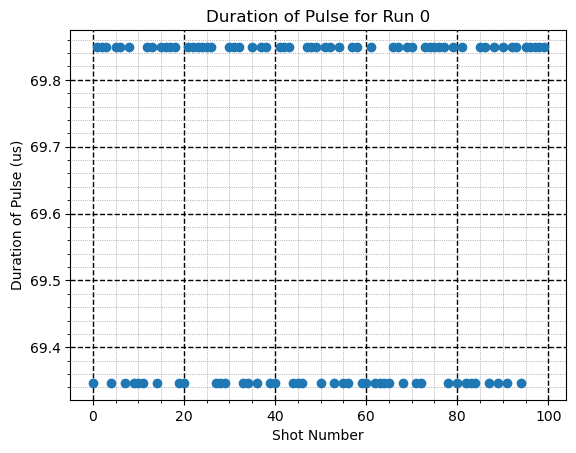

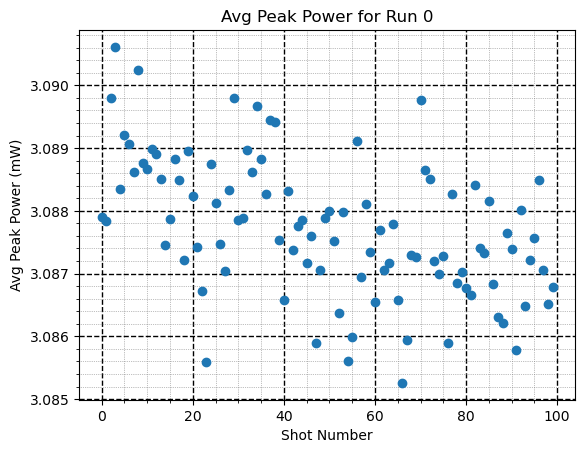

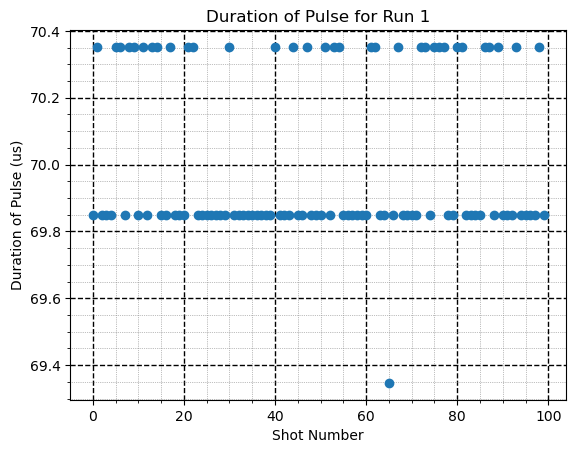

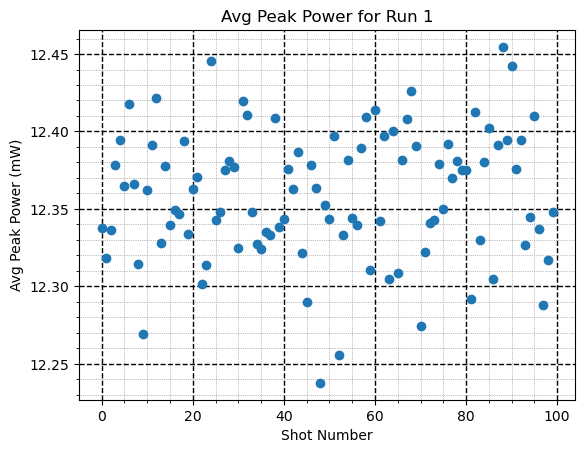

In [7]:
#plot results of interest


for i in range(len(run_names)):
    """
    #plot begin_rise times for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][0] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Timestamp of Begin Rise (us)')
    plt.title('Begin Rise Times for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.show()

    
    #plot duration of rise for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][1] - figs_of_merit[i][j][0] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Duration of Rise (us)')
    plt.title('Duration of Rise for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.show()
    
    
    #plot begin_fall times for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][2] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Timestamp of Begin Fall (us)')
    plt.title('Begin Fall Times for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.show()
    
    #plot duration of fall for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][3] - figs_of_merit[i][j][2] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Duration of Fall (us)')
    plt.title('Duration of Fall for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.show()
    """
    
    #plot duration of pulse for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][2] - figs_of_merit[i][j][0] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Duration of Pulse (us)')
    plt.title('Duration of Pulse for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    #plt.savefig('duration_of_pulse_run' + str(i) + '.png')
    plt.show()


    #plot avg peak power for each shot of each run
    #plt.errorbar(range(num_shots), [figs_of_merit[i][j][4] for j in range(num_shots)], yerr= [figs_of_merit[i][j][5] for j in range(num_shots)], fmt='o')
    plt.plot(range(num_shots), [figs_of_merit[i][j][4] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Avg Peak Power (mW)')
    plt.title('Avg Peak Power for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    #plt.savefig('avg_peak_power_run' + str(i) + '.png')
    plt.show()

    """
    #plot integrated power (energy) for each shot of each run
    plt.plot(range(num_shots), [figs_of_merit[i][j][6] for j in range(num_shots)], 'o')
    plt.xlabel('Shot Number')
    plt.ylabel('Energy of Pulse (mJ)')
    plt.title('Integrated Power over Time for Run ' + str(i))
    plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
    plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
    plt.minorticks_on()
    plt.show()
    """
    
  

In [6]:
#print some statistics from the analysis
for i in range(len(run_names)):
    print("Average MW power in each shot for run " + str(i) +" (mW):", round(np.mean([figs_of_merit[i][j][4] for j in range(num_shots)]), 3))
    print("Std Dev in Avg MW power for each shot for run " + str(i) + " (mW):", round(np.std([figs_of_merit[i][j][4] for j in range(num_shots)]), 3))
    print("Std Dev as percentage of avg value for run " + str(i) + " (%):", round(100*np.std([figs_of_merit[i][j][4] for j in range(num_shots)])/np.mean([figs_of_merit[i][j][4] for j in range(num_shots)]), 3))

Average MW power in each shot for run 0 (mW): 3.088
Std Dev in Avg MW power for each shot for run 0 (mW): 0.001
Std Dev as percentage of avg value for run 0 (%): 0.035
Average MW power in each shot for run 1 (mW): 12.359
Std Dev in Avg MW power for each shot for run 1 (mW): 0.042
Std Dev as percentage of avg value for run 1 (%): 0.338
